## Setup

In [1]:
# POT values for new flux weights

# FHC nu overlay = 2.33978e+21
# FHC nue CC overlay = 2.38181e+22

# RHC nu overlay = 1.98265e+21
# RHC nue CC overlay = 2.53486e+22

# change overlay files (2) and POT values (2) below 

In [2]:
ISOLD = False

ISRUN3 = False # Use for Run 1 or Run 3 data 

isData = True # Should always be set to True 

NUE_INTRINSIC = True

background_subtraction = True 

detsys = True # Turns detector systematic uncertainties for the supplemental plots off 

useBDT = True # Turn back on for all regular paper + supplemental material plots past first lot of variables 

cut_level = ""

In [3]:
import sys

sys.path.insert(0, 'backend_functions')

import selection_functions as sf

import importlib

import uproot 

import matplotlib.pylab as pylab
import numpy as np
import math
from sklearn.model_selection import train_test_split
import pickle
import xgboost as xgb

import awkward
import matplotlib.pyplot as plt
import pandas as pd

import ROOT

# This is our configuration file, cfg.py, which contains the variable names and binning information. 
import cfg
from cfg import * 

import top 
from top import *

import uncertainty_functions 
from uncertainty_functions import *

import xsec_functions 
from xsec_functions import smear_matrix

from ROOT import TH1D, TH2D, TDirectory, TH1F, TH2F

from selection_functions import *

#plt.rcParams['text.usetex'] = True

Welcome to JupyROOT 6.26/10


In [4]:
# Choose your variable!
# Variables = "Opening Angle", "Proton Multiplicity", "Electron Energy", "Visible Energy, BDT Score"
name_of_variable = "Electron Energy" 
xvar, true_var, bins, xlow, xhigh, x_label, x_ticks = get_variable_info(name_of_variable, ISRUN3, cut_level)

From cfg.py...
Variable definition: Electron Energy
Reconstructed variable = shr_energy_cali
True variable = elec_e
Bins = [0.02, 0.22, 0.42, 0.62, 0.82, 1.22, 7.0]
Lowest x-value on plot = 0.02
Highest x-value on plot = 2.5
x-axis title = Electron Energy [GeV]
x-axis labels = [0.02, 0.22, 0.42, 0.62, 0.82, 1.22]


In [5]:
from datetime import datetime
import time
now = datetime.now()
date_time = now.strftime("%H:%M:%S")
print("date and time:",date_time)

date and time: 15:57:03


In [6]:
import NuMIGeoWeights
importlib.reload(NuMIGeoWeights)

if ISRUN3: 
    current = "RHC"
    
else: 
    current = "FHC"

numiBeamlineGeoWeights = NuMIGeoWeights.NuMIGeoWeights(current=current) 

Using current FHC


In [7]:
import NuMIDetSys
importlib.reload(NuMIDetSys)

NuMIDetSysWeights = NuMIDetSys.NuMIDetSys()

In [8]:
plots_path = parameters(ISRUN3)['plots_path']

plots_path

'/Users/patrick/Documents/MicroBooNE/CrossSections/NueCCNp_Analysis/plots/fhc/'

In [9]:
parameters(ISRUN3)['cv_ntuple_path']

'/Users/patrick/Documents/MicroBooNE/CrossSections/NueCCNp_Analysis/samples/run1/slimmed/'

In [10]:
fold = "nuselection"
tree = "NeutrinoSelectionFilter"

DATA = ""
EXT = ""
OVRLY  = ""
DRT = ""
NUE = ""


# slimmed with opening angle 
path = parameters(ISRUN3)['cv_ntuple_path']
print('path = ', path)

if not ISRUN3: 

    # Run 1 FHC 
    OVRLY = 'numi_nu_run1'
    EXT = 'neutrinoselection_filt_run1_beamoff_v5'
    DATA = 'neutrinoselection_filt_run1_beamon_beamgood_v5'
    DRT = 'prodgenie_numi_uboone_overlay_dirt_fhc_mcc9_run1_v28_all_snapshot'
    
    if NUE_INTRINSIC: 
        NUE = 'numi_nue_run1'

else: 
    
    # Run 3 RHC
    OVRLY = 'numi_nu_run3'
    DATA = 'neutrinoselection_filt_run3b_beamon_beamgood_v5'
    EXT = 'neutrinoselection_filt_run3b_beamoff_v5'
    DRT = 'neutrinoselection_filt_run3b_dirt_overlay_v6'
    
    if NUE_INTRINSIC: 
        NUE = 'numi_nue_run3'



path =  /Users/patrick/Documents/MicroBooNE/CrossSections/NueCCNp_Analysis/samples/run1/slimmed/


## Automated Paths

In [11]:
# new flux weights
#overlay = uproot.open("/uboone/data/users/kmiller/uBNuMI_CCNp/ntuples/run1/new_fluxweights/numi_run1_nu_overlay_fhc_slim.root")[fold][tree]
        
if ISOLD:
    overlay = uproot.open(path+OVRLY+".root")[fold][tree]
    
    if NUE_INTRINSIC:
        nue = uproot.open(path+NUE+".root")[fold][tree]

else:
    if ISRUN3:
        overlay = uproot.open("/Users/patrick/Documents/MicroBooNE/CrossSections/NueCCNp_Analysis/samples/run3b/slimmed/numi_nu_run3_slimmed.root")[fold][tree]
        
        if NUE_INTRINSIC:
            nue = uproot.open("/Users/patrick/Documents/MicroBooNE/CrossSections/NueCCNp_Analysis/samples/run3b/slimmed/numi_nue_run3_slimmed.root")[fold][tree]
    
    else:
        overlay = uproot.open("/Users/patrick/Documents/MicroBooNE/CrossSections/NueCCNp_Analysis/samples/run1/slimmed/numi_nu_run1_slimmed.root")[fold][tree]
        
        if NUE_INTRINSIC:
            nue = uproot.open("/Users/patrick/Documents/MicroBooNE/CrossSections/NueCCNp_Analysis/samples/run1/slimmed/numi_nue_run1_slimmed.root")[fold][tree]

data = uproot.open(path+DATA+".root")[fold][tree]
ext = uproot.open(path+EXT+".root")[fold][tree]
dirt = uproot.open(path+DRT+".root")[fold][tree]  

uproot_v = [overlay,data,ext,dirt]

if NUE_INTRINSIC: 
    
    uproot_v.append(nue)


In [12]:
variables = [
    "trk_score_v", 
    "shr_tkfit_dedx_Y", 
    "n_tracks_contained", 
    "NeutrinoEnergy2",
    "run","sub","evt",
    "reco_nu_vtx_sce_x","reco_nu_vtx_sce_y","reco_nu_vtx_sce_z",
    "shrsubclusters0","shrsubclusters1","shrsubclusters2",
    "trkshrhitdist2",
    "n_showers_contained", 
    "shr_phi", "trk_phi", "trk_theta",
    "shr_score", 
    "trk_energy", 
    "tksh_distance", "tksh_angle",
    "shr_energy_tot_cali", "shr_energy_cali", 
    "nslice", 
    "contained_fraction",
    "shrmoliereavg", "shr_px", "shr_py", "shr_pz", "swtrig_pre"
]

# MC only variables
mc_var = ["nu_pdg", "shr_theta", "true_e_visible", "ccnc", 
          "nproton", "nu_e", "npi0", "npion",
          "true_nu_vtx_x", "true_nu_vtx_y" , "true_nu_vtx_z", 
          "weightTune", "weightSpline", "weightSplineTimesTune", 
          "true_nu_px", "true_nu_py", "true_nu_pz", 
          "elec_e", "proton_e", "mc_px", "mc_py", "mc_pz", "elec_px", "elec_py", "elec_pz", 
          "ppfx_cv", "mc_pdg", "opening_angle"]

sys_genie = ["weightsGenie", "weightsReint", 
             "knobRPAup", "knobRPAdn", 
             "knobCCMECup", 
             "knobAxFFCCQEup", 
             "knobVecFFCCQEup", 
             "knobDecayAngMECup", 
             "knobThetaDelta2Npiup", 
             "knobThetaDelta2NRadup", 
             #"knobRPA_CCQE_Reducedup", "knobRPA_CCQE_Reduceddn", # obsolete
             "knobNormCCCOHup", 
             "knobNormNCCOHup",   
             "knobxsr_scc_Fv3up",  # these are supposed to be multisims - 10 universes each -- map to pull out
             "knobxsr_scc_Fa3up"
            ]

sys_flux = ['weightsPPFX']

## Create pandas dataframes

In [13]:
overlay = overlay.pandas.df(variables + mc_var + sys_genie + sys_flux, flatten=False)
#overlay_minimal = overlay.pandas.df(variables, flatten=False)

In [14]:
print(overlay.shape)
#print(overlay_minimal.shape)

(72587, 74)


In [15]:
dirt = dirt.pandas.df(variables + mc_var + sys_genie[:-2] + sys_flux, flatten=False)

In [16]:
dirt['knobxsr_scc_Fv3up'] = 1
dirt['knobxsr_scc_Fa3up'] = 1

In [17]:
if NUE_INTRINSIC: 
    nue = nue.pandas.df(variables + mc_var + sys_genie + sys_flux, flatten=False)

In [18]:
data = data.pandas.df(variables, flatten=False) 

In [19]:
ext = ext.pandas.df(variables, flatten=False)

In [20]:
for var in mc_var+sys_genie+sys_flux: 
    data[var] = np.nan
    ext[var] = np.nan

In [21]:
# is dirt bool

overlay['isDirt'] = False
dirt['isDirt'] = True

if NUE_INTRINSIC: 
    nue['isDirt'] = False
    
data['isDirt'] = np.nan
ext['isDirt'] = np.nan

In [22]:
# how to get the LLR-PID value for the "track candidate" 
# (proton for nue selection, muon for numu)
# can be done for any variable
# code from Giuseppe!
#LLR-PID : log likelihood ratio particle ID 

df_v = [overlay,data,ext,dirt]

if NUE_INTRINSIC: 
    df_v.append(nue)
    
for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_llr_pid_v = up.array('trk_llr_pid_score_v')
    trk_id = up.array('trk_id')-1 # I think we need this -1 to get the right result
    trk_llr_pid_v_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
    df['trkpid'] = trk_llr_pid_v_sel
    df['subcluster'] = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']
    
    df['NeutrinoEnergy2_GeV'] = df['NeutrinoEnergy2']/1000

    # Correction for reconstructed electron energy
    if not ISOLD:
        
        df['shr_energy_cali'] = df['shr_energy_cali'] / 0.83


In [23]:
overlay = overlay.query('swtrig_pre==1')
dirt = dirt.query('swtrig_pre==1')
nue = nue.query('swtrig_pre==1')

In [24]:
print(overlay.shape)
print(nue.shape)

(72508, 78)
(48967, 78)


In [25]:
mc_df = [overlay, dirt]

if NUE_INTRINSIC: 
    mc_df.append(nue)

In [26]:
# Add truth level theta & phi angles (detector & beam coordinates)
overlay = addAngles(overlay)
dirt = addAngles(dirt)

# Angles already added!
if NUE_INTRINSIC: 
    nue = addAngles(nue)

/Users/patrick/Documents/MicroBooNE/CrossSections/NueCCNp_Analysis/uB_NuMI_CC_Np/backend_functions/top.py:743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['thdet'] = np.arctan2(((df['true_nu_px']*df['true_nu_px'])+(df['true_nu_py']*df['true_nu_py']))**(1/2), df['true_nu_pz'])*(180/math.pi)
/Users/patrick/Documents/MicroBooNE/CrossSections/NueCCNp_Analysis/uB_NuMI_CC_Np/backend_functions/top.py:744: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['phidet'] = np.arctan2(df['true_nu_py'], df['true_nu_px'

In [27]:
for i,df in enumerate(mc_df):
    # is signal bool 
    df['is_signal'] = np.where((df.swtrig_pre == 1) 
                             & (df.nu_pdg==12) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0)
                             & (10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                             & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                             & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)

/var/folders/2x/l68t7zdd3tngj9l8__x4bmrh0000gq/T/ipykernel_59470/3661105688.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_signal'] = np.where((df.swtrig_pre == 1)
/var/folders/2x/l68t7zdd3tngj9l8__x4bmrh0000gq/T/ipykernel_59470/3661105688.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_signal'] = np.where((df.swtrig_pre == 1)


In [28]:
for i,df in enumerate(mc_df):
  
    # get right order of magnitude for multiverses
    df['weightsPPFX'] = df['weightsPPFX']/1000
    df['weightsGenie'] = df['weightsGenie']/1000
    df['weightsReint'] = df['weightsReint']/1000
    
    # add beamline geometry weights
    df['weightsNuMIGeo'] = df.apply( lambda x: numiBeamlineGeoWeights.calculateGeoWeight(x['nu_pdg'],x['nu_e'],x['thbeam']) , axis=1)
 

/var/folders/2x/l68t7zdd3tngj9l8__x4bmrh0000gq/T/ipykernel_59470/1880286884.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['weightsPPFX'] = df['weightsPPFX']/1000
/var/folders/2x/l68t7zdd3tngj9l8__x4bmrh0000gq/T/ipykernel_59470/1880286884.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['weightsGenie'] = df['weightsGenie']/1000
/var/folders/2x/l68t7zdd3tngj9l8__x4bmrh0000gq/T/ipykernel_59470/1880286884.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

In [29]:
# corrected visible energy variable - account for electrons below 30 MeV 
# use this variable for the visible energy unfolding 

visible_energy_nothres(overlay)
visible_energy_nothres(dirt)

/Users/patrick/Documents/MicroBooNE/CrossSections/NueCCNp_Analysis/uB_NuMI_CC_Np/backend_functions/top.py:408: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['elec_ke'] = df.elec_e - 0.000511
/Users/patrick/Documents/MicroBooNE/CrossSections/NueCCNp_Analysis/uB_NuMI_CC_Np/backend_functions/top.py:424: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['true_e_visible2'] = E_vis_new
/Users/patrick/Documents/MicroBooNE/CrossSections/NueCCNp_Analysis/uB_NuMI_CC_Np/backend_functions/top.py:408: SettingWithCopyW

In [30]:
# make dataframes equal # of columns 

data['is_signal'] = np.nan
ext['is_signal'] = False

nan_var = ['thdet', 'phidet', 'true_nu_px_beam', 'true_nu_py_beam', 'true_nu_pz_beam', 
           'thbeam', 'phibeam','weightsNuMIGeo', 'true_e_visible2']

for var in mc_var+sys_genie+sys_flux+nan_var: 
    data[var] = np.nan
    ext[var] = np.nan

In [31]:
# some checks 
print(len(nue.query('is_signal==True'))==len(nue.query(signal)))
print(len(nue.query('is_signal==False'))==len(nue.query(not_signal)))

True
True


In [32]:
ISRUN3

False

## Weights

In [33]:
# clean bad weights & values 

for i,df in enumerate(mc_df):
    
    print(i)
    
    # bad weights 
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 30, 'weightSplineTimesTune' ] = 1.
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1.
    
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 30, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.

    df.loc[ df['ppfx_cv'] <= 0, 'ppfx_cv' ] = 1.
    df.loc[ df['ppfx_cv'] == np.inf, 'ppfx_cv' ] = 1.
    df.loc[ df['ppfx_cv'] > 30, 'ppfx_cv' ] = 1.
    df.loc[ np.isnan(df['ppfx_cv']) == True, 'ppfx_cv' ] = 1.
    
                
    # CLEAN GENIE UNISIM WEIGHTS & CREATE WEIGHTSGENIEUNISIM LIST 
    for v in sys_genie[2:]: 
        df.loc[ df[v] <= 0, v ] = 1.
        df.loc[ df[v] == np.inf, v ] = 1.
        df.loc[ df[v] > 30, v ] = 1.
        df.loc[ np.isnan(df[v]) == True, v ] = 1.
        
    universes = []
    for evt in df[sys_genie[2:]].values: 
        universes.append( evt )
            
    df['weightsGenieUnisim'] = universes

        
    # cleaning -- for entries that are arrays 
    for ievt in range(df.shape[0]):
        
        # GENIE MULTISIMS
        
        # check for NaNs separately        
        if np.isnan(df['weightsGenie'].iloc[ievt]).any() == True: 
            df['weightsGenie'].iloc[ievt][ np.isnan(df['weightsGenie'].iloc[ievt]) ] = 1.
            
        reweightCondition = ((df['weightsGenie'].iloc[ievt] > 30) | (df['weightsGenie'].iloc[ievt] < 0)  | 
                             (df['weightsGenie'].iloc[ievt] == np.inf) | (df['weightsGenie'].iloc[ievt] == np.nan))
        df['weightsGenie'].iloc[ievt][ reweightCondition ] = 1.
        
        # if no variations exist for the event
        if not list(df['weightsGenie'].iloc[ievt]): 
            df['weightsGenie'].iloc[ievt] = [1.0 for k in range(600)]
        
        # RE-INTERACTION WEIGHTS
        
        # check for NaNs separately        
        if np.isnan(df['weightsReint'].iloc[ievt]).any() == True: 
            df['weightsReint'].iloc[ievt][ np.isnan(df['weightsReint'].iloc[ievt]) ] = 1.
        
        reweightCondition2 = ((df['weightsReint'].iloc[ievt] > 30) | (df['weightsReint'].iloc[ievt] < 0)   |
                             (df['weightsReint'].iloc[ievt] == np.inf))
        df['weightsReint'].iloc[ievt][ reweightCondition2 ] = 1.
        
        # if no variations exist for the event
        if not list(df['weightsReint'].iloc[ievt]): 
            df['weightsReint'].iloc[ievt] = [1.0 for k in range(1000)]
            

0


/var/folders/2x/l68t7zdd3tngj9l8__x4bmrh0000gq/T/ipykernel_59470/3081178329.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['weightsGenieUnisim'] = universes


1


/var/folders/2x/l68t7zdd3tngj9l8__x4bmrh0000gq/T/ipykernel_59470/3081178329.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['weightsGenieUnisim'] = universes


2


In [34]:
# POT normalization

beamon_pot = parameters(ISRUN3)['beamon_pot'] 

overlay = pot_scale(overlay, 'overlay', ISRUN3)

## FHC new flux weights 
##overlay['pot_scale'] = beamon_pot/2.33978e+21

## RHC new flux weights 
##overlay['pot_scale'] = beamon_pot/1.98265e+21

dirt = pot_scale(dirt, 'dirt', ISRUN3)
ext = pot_scale(ext, 'ext', ISRUN3)

if NUE_INTRINSIC: 
    nue = pot_scale(nue, 'intrinsic', ISRUN3)
    
    ## FHC new flux weights 
    ##nue['pot_scale'] = beamon_pot/2.38181e+22
    
    ## RHC new flux weights 
    ##nue['pot_scale'] = beamon_pot/2.53486e+22

data['pot_scale'] = [1 for x in range(len(data))]


Adding pot_scale column using dirt & EXT tune....
Adding pot_scale column using dirt & EXT tune....
Adding pot_scale column using dirt & EXT tune....
Adding pot_scale column using dirt & EXT tune....


In [35]:
# total weights 

# combined genie * POT weight * flux weight 
# ext gets POT weight only 

################################################################
# totweight_data scales to BEAMON

# tuned
overlay['totweight_data'] = overlay['pot_scale']*overlay['ppfx_cv']*overlay['weightSplineTimesTune']
dirt['totweight_data'] = dirt['pot_scale']*dirt['ppfx_cv']*dirt['weightSplineTimesTune']

if NUE_INTRINSIC: 
    nue['totweight_data'] = nue['pot_scale']*nue['ppfx_cv']*nue['weightSplineTimesTune']


In [36]:
# to keep the number of columns the same 

new_var = ['weightsGenieUnisim', 'totweight_data']

for var in new_var: 
    ext[var] = np.nan
    data[var] = np.nan

## Categories

In [37]:
# replace overlay nue CC events with nue intrinsic sample

#overlay = pd.concat([overlay,nue], ignore_index=True)

if NUE_INTRINSIC: 
    
    # intrinsic sample contains in AV TPC events ONLY, & only CC events (overlay is entire cryo)
    print("# of nueCC in AV in overlay sample = "+str(len(overlay.query(nueCC_query))))
    len1 = len(overlay)
    
    idx = overlay.query(nueCC_query).index
    overlay.drop(idx, inplace=True)
    len2 = len(overlay) 
    print("# of nueCC in AV dropped in overlay = "+str(len1-len2))
    
    overlay = pd.concat([overlay,nue], ignore_index=True)



# of nueCC in AV in overlay sample = 4650
# of nueCC in AV dropped in overlay = 4650


In [38]:
print(overlay.shape)

(116825, 92)


In [39]:
# apply SW trigger, combine overlay + dirt as MC 
mc = pd.concat([overlay.query('swtrig_pre==1'),dirt.query('swtrig_pre==1')], ignore_index=True, sort=True)


In [40]:
# separate by in/out FV & cosmic
infv = mc.query(in_fv_query)
outfv = mc.query(out_fv_query)

In [41]:
# check that everything is accounted for 
print(len(mc)==len(infv)+len(outfv))#+len(cosmic))

if not (len(mc)==len(infv)+len(outfv)):#+len(cosmic)): 
    d = len(mc) - (len(infv)+len(outfv))#+len(cosmic))
    print(d)
    
     
    m = pd.concat([infv, outfv]) #pd.concat([infv, cosmic, outfv])
    diff = np.setdiff1d(list(mc.index),list(m.index))


True


In [42]:
tot_signal_weighted = np.nansum(infv.query('is_signal==True')['totweight_data'])
print('total signal events = '+ str(tot_signal_weighted))


total signal events = 250.88747502856478


In [43]:
# 5 main categories: 

# infv - overlay & dirt events with truth vtx in FV 
# outfv - overlay & dirt events with truth vtx in FV that are classified as neutrinos
# cosmic - overlay & dirt events with true vtx in FV that get misclassified as cosmic - no longer used 
# ext - beam OFF data
# data - beam ON data 

datasets = {
    "infv": infv, 
    "outfv": outfv, 
    "ext": ext,
    "data": data
}


In [44]:
ISRUN3

False

# Apply BDT Model 

In [45]:
if useBDT: # load bdt model 
    bdt_model = xgb.Booster({'nthread': 4})
    bdt_model.load_model(parameters(ISRUN3)['bdt_model'])

/opt/homebrew/Caskroom/miniconda/base/envs/ccnpenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:58:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1070: Loading model from XGBoost < 1.0.0, consider saving it again for improved compatibility
  warnings.warn(smsg, UserWarning)


In [46]:
if useBDT: 
    
    datasets_bdt = {}

    for i in range(len(datasets)): 

        df = list(datasets.values())[i].copy()
        df = df.query(BDT_LOOSE_CUTS)

        # clean datasets 
        for column in training_parameters:
            df.loc[(df[column] < -1.0e37) | (df[column] > 1.0e37), column] = np.nan

        # create testing dmatrix 
        df_test = xgb.DMatrix(data=df[training_parameters])

        # apply the bdt selection
        preds = bdt_model.predict(df_test)

        # add columns for plotting 
        df['BDT_score'] = preds

        datasets_bdt[list(datasets.keys())[i]] = df

  
    

In [47]:
if useBDT: 
    bdt_score_cut = parameters(ISRUN3)['bdt_score_cut']

    print("BDT SCORE THRESHOLD = "+str(bdt_score_cut))

    selected_query = BDT_LOOSE_CUTS + ' and BDT_score>'+str(bdt_score_cut)
    selected_signal_query = selected_query + ' and is_signal==True'

BDT SCORE THRESHOLD = 0.55


total selected = 288.63785597597223


/Users/patrick/Documents/MicroBooNE/CrossSections/NueCCNp_Analysis/uB_NuMI_CC_Np/backend_functions/selection_functions.py:379: RuntimeWarning: invalid value encountered in divide
  ext_percent_err = np.sqrt(ext_counts)/n[-1]
/Users/patrick/Documents/MicroBooNE/CrossSections/NueCCNp_Analysis/uB_NuMI_CC_Np/backend_functions/selection_functions.py:380: RuntimeWarning: invalid value encountered in divide
  mc_percent_err = mc_err/n[-1]


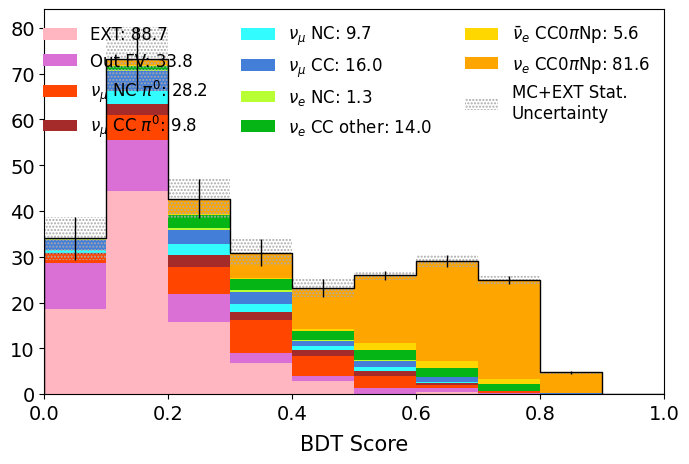

In [48]:
# stat only errors 
if useBDT: 
    x = plot_mc('BDT_score', [x*0.1 for x in range(11)], 0, 1, BDT_LOOSE_CUTS, datasets_bdt, 
                ISRUN3, x_label="BDT Score", norm='data')

# Uncertainties (and choose variable!)

In [49]:
import matplotlib
matplotlib.rcParams['mathtext.default'] = 'regular'

In [50]:
ISRUN3

False

In [51]:
#detsys = True

plot_variations = False
plot_cov = False

y_label = 'Events / Bin'

# Determine the datasets dictionary to use
if cut_level == "bdt train":
    datasets_dict = datasets  # Force to use datasets if cut_level is "bdt train"
else:
    datasets_dict = datasets_bdt if background_subtraction or xvar == 'BDT_score' or useBDT else datasets

print("Make sure to update the datasets dictionary used!")


Make sure to update the datasets dictionary used!


In [52]:
print("datasets_dict:", datasets_dict) 

datasets_dict: {'infv':         NeutrinoEnergy2  NeutrinoEnergy2_GeV  ccnc  contained_fraction  \
21           444.333557             0.444334     1                 1.0   
170          262.973633             0.262974     0                 1.0   
178          494.749207             0.494749     1                 1.0   
278          239.671875             0.239672     0                 1.0   
310          534.271301             0.534271     1                 1.0   
...                 ...                  ...   ...                 ...   
116804       419.921387             0.419921     0                 1.0   
116805       730.411255             0.730411     0                 1.0   
116808      1178.401611             1.178402     0                 1.0   
116815       709.813904             0.709814     0                 1.0   
116820       529.418091             0.529418     0                 1.0   

          elec_e   elec_ke       elec_px       elec_py       elec_pz    evt  \
21      

In [53]:
# PRESELECTION QUERY
PRE_SELECTION = (
    'swtrig_pre==1 and nslice==1' +
    ' and ' + reco_in_fv_query +
    ' and contained_fraction>0.9' +
    ' and n_showers_contained==1' +
    ' and n_tracks_contained>0' +
    ' and trk_energy>0.04'
)

# NUMU REJECTION
NUMU_REJECTION = (
    'shr_score<0.3' + 
    ' and trkpid<0.35'
)

q_options = {
    "pre-selection": PRE_SELECTION,
    "numu": PRE_SELECTION + ' and ' + NUMU_REJECTION,
    "bdt train": BDT_LOOSE_CUTS + ' and -0.9<tksh_angle<0.9 and shr_energy_tot_cali>0.07' 
    # BDT_LOOSE_CUTS on it's own with datasets_bdt is trained! 
}

if cut_level == "":  # Defaults 
    if name_of_variable == "BDT Score":
        q = BDT_LOOSE_CUTS
    else:
        q = BDT_LOOSE_CUTS + ' and BDT_score>' + str(parameters(ISRUN3)['bdt_score_cut'])
else:
    # Default behavior based on q_options
    q = q_options.get(cut_level, PRE_SELECTION)

In [54]:
q

'swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and trkpid<0.35 and tksh_distance<12 and BDT_score>0.55'

total selected = 71.22455736188456


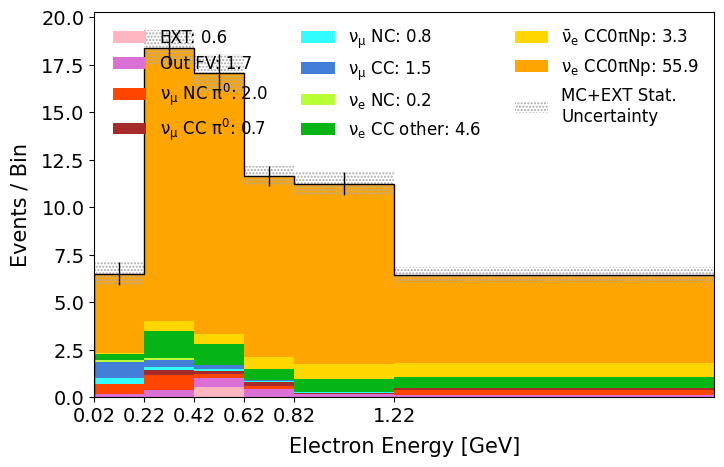

[6.502252487625011,
 18.39790434401941,
 17.045215012213227,
 11.629242932898498,
 11.222152334197062,
 6.427790250931366]

In [55]:
# stat only -- SCALES TO DATA

full_event_rate = plot_mc(xvar, bins, xlow, xhigh, q, datasets_dict, ISRUN3, 
            norm='data', save=False, x_ticks=x_ticks,
                         x_label=x_label, y_label=y_label)['CV']
full_event_rate

total selected = 71.22455736188456


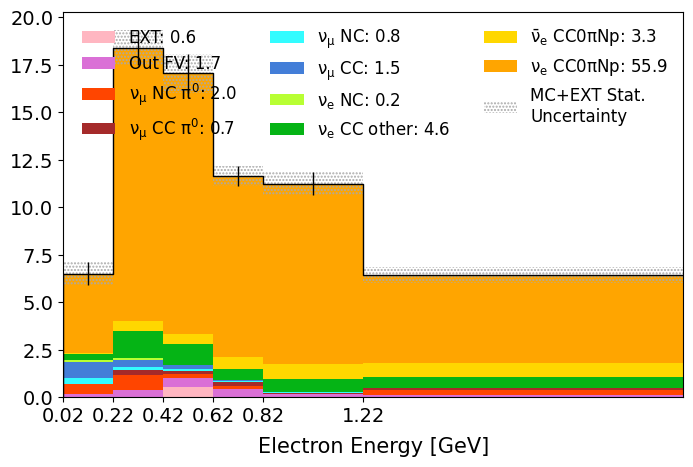

In [56]:
bkgd_event_rate = plot_mc(xvar, bins, xlow, xhigh, q, datasets_dict, ISRUN3, 
            norm='data', x_label=x_label, save=False, x_ticks=x_ticks)['background_counts']


In [57]:
print(bkgd_event_rate)

[2.3308193271598787, 4.013941238664677, 3.3303930601434475, 2.1234668584282144, 1.7303904411056688, 1.8000609026213117]


### Background subtraction

In [58]:
if background_subtraction: # use the estimated signal event rate only 
    evt_rate = [x-y for x,y in zip(full_event_rate,bkgd_event_rate)]
    
else: 
    evt_rate = full_event_rate


In [59]:
print(evt_rate)

[4.171433160465132, 14.38396310535473, 13.71482195206978, 9.505776074470283, 9.491761893091393, 4.627729348310055]


### PPFX

In [60]:
ISRUN3

False

In [61]:
ncv_nu, ppfx_variations = plotSysVariations(xvar, true_var, bins, xlow, xhigh, q, datasets_dict, 'weightsPPFX',
                                         600,ISRUN3, plot=plot_variations, axis_label='Reco '+x_label, 
                                         pot=str(beamon_pot)+" POT", background_subtraction=background_subtraction)

Implementing background subtraction .... 


In [62]:
ppfx_dict = calcCov(xvar, bins, ncv_nu, evt_rate, ppfx_variations, plot=plot_cov, save=False, 
                    axis_label='Reco '+x_label, pot=str(beamon_pot)+" POT", isrun3=ISRUN3)

number of universes =  600


In [63]:
ppfx_dict['fractional_uncertainty']

array([0.32883659, 0.24257335, 0.23329759, 0.25576567, 0.23582974,
       0.26368235])

### Beamline Geometry

In [64]:
# ordered by beamline variation run number
# [+1sigma run #, -1sigma run #]

beamline_variations = []

beamline_runs = {
    'HornCurrent' : [1, 2], 
    'xHorn1' : [3, 4], 
    'yHorn1' : [5, 6], 
    'BeamSpotSize' : [7, 8], 
    'xHorn2' : [9, 10], 
    'yHorn2' : [11, 12], 
    'WaterOnHorns' : [13, 14], 
    'xBeamShift' : [15, 16], 
    'yBeamShift' : [17, 18], 
    'zTargetPosition' : [19, 20]    
}

beamline_cov = {}

# index in weightsNuMIGeo are offset by -1

for variation in beamline_runs.keys(): 
    
    idx = [i-1 for i in beamline_runs[variation]]
    print(idx)
    
    ncv_nu, variations = plotSysVariations(xvar, true_var, bins, xlow, xhigh, q, datasets_dict, 'weightsNuMIGeo', 
                                                 idx, ISRUN3, plot=plot_variations, 
                                                 axis_label='Reco '+x_label, pot=str(beamon_pot)+" POT", 
                                                  background_subtraction=background_subtraction, title=variation)
    
    beamline_variations.append([list(a) for a in variations])
    
    # calc covariance 
    beamline_cov[variation] = calcCov(xvar, bins, ncv_nu, evt_rate, 
                                      variations, plot=plot_cov, save=False, 
                    axis_label='Reco '+x_label, pot=str(beamon_pot)+" POT", isrun3=ISRUN3)
    



[0, 1]
Implementing background subtraction .... 
number of universes =  2
[2, 3]
Implementing background subtraction .... 
number of universes =  2
[4, 5]
Implementing background subtraction .... 
number of universes =  2
[6, 7]
Implementing background subtraction .... 
number of universes =  2
[8, 9]
Implementing background subtraction .... 
number of universes =  2
[10, 11]
Implementing background subtraction .... 
number of universes =  2
[12, 13]
Implementing background subtraction .... 
number of universes =  2
[14, 15]
Implementing background subtraction .... 
number of universes =  2
[16, 17]
Implementing background subtraction .... 
number of universes =  2
[18, 19]
Implementing background subtraction .... 
number of universes =  2


In [65]:
# compute total covariance, correlation, & uncertainty 

cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
frac_cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
cor = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]

for variation in beamline_cov.keys(): 
    
    for i in range(len(bins)-1): 
        for j in range(len(bins)-1):
            
            cov[i][j] += beamline_cov[variation]['cov'][i][j]
            frac_cov[i][j] += beamline_cov[variation]['frac_cov'][i][j] 

            
for i in range(len(bins)-1): 
    for j in range(len(bins)-1):
        
        if np.sqrt(cov[i][i])*np.sqrt(cov[j][j]) != 0: 
                cor[i][j] = cov[i][j] / (np.sqrt(cov[i][i])*np.sqrt(cov[j][j]))
            
beamline_dict = {
    'cov' : cov, 
    'frac_cov' : frac_cov,
    'cor' : cor,
    'fractional_uncertainty' : np.sqrt(np.diag(frac_cov))
} 

beamline_dict['fractional_uncertainty']

array([0.03043864, 0.03512438, 0.03260633, 0.03668955, 0.057833  ,
       0.05656093])

### GENIE multisims

Implementing background subtraction .... 
Adding pot_scale column using dirt & EXT tune....
TOTAL CV GENERATED SIGNAL EVENTS (TRUE) =  [37.38995279317464, 99.80981090014366, 86.4593379915033, 64.4000072570546, 66.41697559589346, 53.220929881038956]


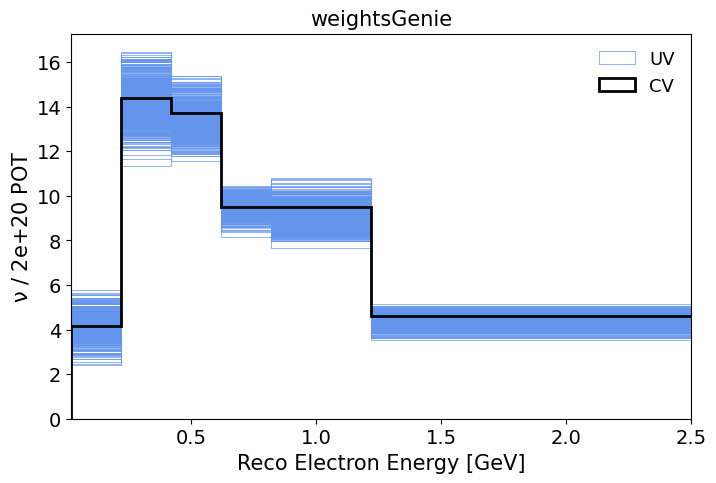

In [66]:
ncv_nu, genie_variations = plotSysVariations(xvar, true_var, bins, xlow, xhigh, q, datasets_dict, 'weightsGenie', 600, 
                                         ISRUN3, plot=True, axis_label='Reco '+x_label, 
                                          pot=str(beamon_pot)+" POT", 
                                              background_subtraction=background_subtraction)

In [67]:
genie_dict = calcCov(xvar, bins, ncv_nu, evt_rate, genie_variations, plot=plot_cov, save=False, 
                    axis_label='Reco '+x_label, pot=str(beamon_pot)+" POT", isrun3=ISRUN3)

number of universes =  600


In [68]:
genie_dict['fractional_uncertainty']

array([0.12834669, 0.06589309, 0.05385348, 0.03852199, 0.06824858,
       0.07247241])

### GENIE unisims 

In [69]:

# divide the tune weight out of everything except SCC variations
# don't divide the tune weight out of SCC variations 

genie_unisim_variations = ['RPA', 
                           'CCMEC', 'AxFFCCQE', 'VecFFCCQE', 'DecayAngMEC', 'ThetaDelta2Npi', 'ThetaDelta2NRad', 
                          'NormCCCOH', 'NormNCCOH', 
                          'xsr_scc_Fv3', 'xsr_scc_Fa3']


genie_unisim_cov = {}

genie_us_variations = []

for knob in genie_unisim_variations: 
    
    if knob == 'RPA': 
        idx = [sys_genie[2:].index('knobRPAup'), sys_genie[2:].index('knobRPAdn')]
    
    else: 
        idx = [sys_genie[2:].index('knob'+knob+'up')]
    
    ncv_nu, variations = plotSysVariations(xvar, true_var, bins, xlow, xhigh, q, datasets_dict, 'weightsGenieUnisim', 
                                        idx, ISRUN3, plot=plot_variations, axis_label='Reco '+x_label, 
                                        pot=str(beamon_pot)+" POT", 
                                        background_subtraction=background_subtraction, title=knob)
    
    genie_us_variations.append([list(a) for a in variations])
    
    # calc covariance 
    genie_unisim_cov[knob] = calcCov(xvar, bins, ncv_nu, evt_rate, variations, plot=plot_cov, save=False, 
                    axis_label='Reco '+x_label, pot=str(beamon_pot)+" POT", isrun3=ISRUN3)
    

Implementing background subtraction .... 
Adding pot_scale column using dirt & EXT tune....
45756.42923687927
44913.46255116047
number of universes =  2
Implementing background subtraction .... 
Adding pot_scale column using dirt & EXT tune....
45334.721682743744
number of universes =  1
Implementing background subtraction .... 
Adding pot_scale column using dirt & EXT tune....
45324.58491543919
number of universes =  1
Implementing background subtraction .... 
Adding pot_scale column using dirt & EXT tune....
45265.04215317032
number of universes =  1
Implementing background subtraction .... 
Adding pot_scale column using dirt & EXT tune....
45165.87844056617
number of universes =  1
Implementing background subtraction .... 
Adding pot_scale column using dirt & EXT tune....
46160.151847704
number of universes =  1
Implementing background subtraction .... 
Adding pot_scale column using dirt & EXT tune....
45334.721682743744
number of universes =  1
Implementing background subtraction .

In [70]:
# compute total covariance, correlation, & uncertainty 

cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
frac_cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
cor = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]

for variation in genie_unisim_cov.keys(): 
    
    for i in range(len(bins)-1): 
        for j in range(len(bins)-1):
            
            cov[i][j] += genie_unisim_cov[variation]['cov'][i][j]
            frac_cov[i][j] += genie_unisim_cov[variation]['frac_cov'][i][j] 

            
for i in range(len(bins)-1): 
    for j in range(len(bins)-1):
        
        if np.sqrt(cov[i][i])*np.sqrt(cov[j][j]) != 0: 
                cor[i][j] = cov[i][j] / (np.sqrt(cov[i][i])*np.sqrt(cov[j][j]))
        
            
genie_unisim_dict = {
    'cov' : cov, 
    'frac_cov' : frac_cov,
    'cor' : cor,
    'fractional_uncertainty' : np.sqrt(np.diag(frac_cov))
} 

genie_unisim_dict['fractional_uncertainty']

array([0.2336922 , 0.07495237, 0.02397763, 0.03425169, 0.01462482,
       0.05346048])

### GEANT4 

In [71]:
ncv_nu, geant4_variations = plotSysVariations(xvar, true_var, bins, xlow, xhigh, q, datasets_dict, 'weightsReint', 1000, 
                                         ISRUN3, plot=plot_variations, axis_label='Reco '+x_label, pot=str(beamon_pot)+" POT", 
                                              background_subtraction=background_subtraction)



Implementing background subtraction .... 


In [72]:
geant4_dict = calcCov(xvar, bins, ncv_nu, evt_rate, geant4_variations, plot=plot_cov, save=False, 
                    axis_label='Reco '+x_label, pot=str(beamon_pot)+" POT", isrun3=ISRUN3)

number of universes =  1000


In [73]:
geant4_dict['fractional_uncertainty']

array([0.03832045, 0.02056306, 0.01414969, 0.01110995, 0.02098012,
       0.02750094])

### Detector Systematics

#### Create ROOT file with BDT-selected detector variations 

In [74]:
detsys_flat = True
recreate_file = False

#detvar_file = "NuMI_RHC_BDTscore_BDTCut_DetVar_MAY2023.root" 

In [75]:
ISRUN3

False

In [76]:
if not detsys_flat: 

    if ISRUN3: 
        detvar = detvar_run3_rhc.keys()

    else: 
        detvar = detvar_run1_fhc.keys()
        
    # skip this step if it is already created
    # should manually delete the file first 
    # (located here: /uboone/data/users/kmiller/uBNuMI_CCNp/ntuples/runX/systematics/detvar/)

    # scales to the det sys CV POT (standard overlay)

    if recreate_file: 
        for v in list(detvar): 
            NuMIDetSysWeights.makehist_detsys(v, ISRUN3, detvar_file, xvar, bins, cut=q, useBDT=True, 
                                             background_subtraction=background_subtraction)
            
        detector_variations = NuMIDetSysWeights.plot_variations(xvar, bins, 
                                                            detvar_file,  
                                                            ISRUN3, axis_label=x_label, 
                                                            plot=True, background_subtraction=background_subtraction)


In [77]:
# compute total covariance, correlation, & uncertainty 

cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
frac_cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
cor = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]

detsys_dict = {}

In [78]:
# compute covariance (N=1 for each variation)
# detvar are scaled to beam on POT at this point

if not detsys_flat:

    detsys_cov = {}

    for variation in detector_variations.keys(): 

        if variation=='CV': 
            continue

        # calc covariance for each unisim 
        detsys_cov[variation] = calcCov(xvar, bins, detector_variations['CV'], detector_variations['CV'], 
                                        [detector_variations[variation]], 
                                        plot=False, save=False, axis_label='Reco '+x_label, pot=str(beamon_pot)+" POT", 
                                        isrun3=ISRUN3)
        
    for i in range(len(bins)-1): 
        for j in range(len(bins)-1):
            
            cov[i][j] = sum([detsys_cov[x]['cov'][i][j] for x in detsys_cov.keys()])
            frac_cov[i][j] = sum([detsys_cov[x]['frac_cov'][i][j] for x in detsys_cov.keys()])

    for i in range(len(bins)-1): 
        for j in range(len(bins)-1):

            if np.sqrt(cov[i][i])*np.sqrt(cov[j][j]) != 0: 
                    cor[i][j] = cov[i][j] / (np.sqrt(cov[i][i])*np.sqrt(cov[j][j]))

    detsys_dict['cov'] = cov
    detsys_dict['frac_cov'] = frac_cov
    detsys_dict['cor'] = cor
    detsys_dict['fractional_uncertainty'] = np.sqrt(np.diag(frac_cov))


In [79]:
if detsys_flat:
    
    detsys_dict['fractional_uncertainty'] = []
    
    for i in range(len(bins)-1): 
        
        if evt_rate[i] != 0: 
            detsys_dict['fractional_uncertainty'].append(parameters(ISRUN3)['detsys_flat'])
            frac_cov[i][i] = parameters(ISRUN3)['detsys_flat']**2
        else: 
            detsys_dict['fractional_uncertainty'].append(0)
            
                
    
    print((detsys_dict['fractional_uncertainty']))
    
    
            
            

[0.122, 0.122, 0.122, 0.122, 0.122, 0.122]


In [80]:
detsys_dict['frac_cov'] = frac_cov

### Stat Uncertainty of the MC event count 

In [81]:
# sum of the weights squared

mc_stat_cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
mc_frac_stat_cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]

# also save sumw2 of the estimated signal and neutrino background
mc_signal_sumw2 = []
mc_bkgd_sumw2 = []


In [82]:
# for data/mc comparisons
if background_subtraction==False: 
    
    # stat uncertainty for MC - signal + background 
    ncv = pd.concat([datasets_dict['infv'].copy().query(q), 
                             datasets_dict['outfv'].copy().query(q)], ignore_index=True)  

if background_subtraction==True: 

    if isData==True: 
        ncv = pd.concat([datasets_dict['infv'].copy().query(q+' and is_signal==False'), 
                                         datasets_dict['outfv'].copy().query(q+' and is_signal==False')], 
                                ignore_index=True) 

    # GENIE closure test: take sum of weights squared for the full event count 
    else: 
        ncv = pd.concat([datasets_dict['infv'].copy().query(q), 
                             datasets_dict['outfv'].copy().query(q)], ignore_index=True) 


In [83]:
for i in range(len(bins)-1):

    if i==len(bins)-2: 
        bin_query = xvar+'>='+str(bins[i])+' and '+xvar+'<='+str(bins[i+1])
    else: 
        bin_query = xvar+'>='+str(bins[i])+' and '+xvar+'<'+str(bins[i+1])
        
    mc_stat_cov[i][i] = sum(ncv.query(bin_query).totweight_data ** 2) 
    
    mc_signal_sumw2.append(sum(datasets_dict['infv'].copy().query(q+' and is_signal==True and '+bin_query).totweight_data ** 2) )
    mc_bkgd_sumw2.append( sum(pd.concat([datasets_dict['infv'].copy().query(q), 
                                        datasets_dict['outfv'].copy().query(q)], ignore_index=True).query("is_signal==False and "+bin_query).totweight_data **2 ))

    if mc_stat_cov[i][i] != 0: 
        mc_frac_stat_cov[i][i] = mc_stat_cov[i][i]/ evt_rate[i]**2 
    
    bin_query = ''
    
mc_stat_percent_error = np.sqrt(np.diag(mc_frac_stat_cov))
mc_stat_percent_error

array([0.12936404, 0.05116709, 0.02821116, 0.03259494, 0.02557086,
       0.06574572])

In [84]:
if plot_cov: 
    fig = plt.figure(figsize=(10, 6))
        
    plt.pcolor(bins, bins, mc_stat_cov, cmap='OrRd', edgecolors='k' )

    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=14)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.xlabel("Reco "+x_label, fontsize=15)
    plt.ylabel("Reco "+x_label, fontsize=15)

    plt.title('MC Statistical Covariance', fontsize=15)

    plt.show()
    
    fig = plt.figure(figsize=(10, 6))
        
    plt.pcolor(bins, bins, mc_frac_stat_cov, cmap='OrRd', edgecolors='k' )

    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=14)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.xlabel("Reco "+x_label, fontsize=15)
    plt.ylabel("Reco "+x_label, fontsize=15)

    plt.title('MC Fractional Statistical Covariance', fontsize=15)

    plt.show()


### Stat Uncertainty Beam On & EXT

In [85]:
# EXT uses sum of the weights squared 
selected_ext = datasets_dict['ext'].copy().query(q)

In [86]:
ext_stat_cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
ext_frac_stat_cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
    
for i in range(len(bins)-1):

    if i==len(bins)-2: 
        bin_query = xvar+' >= '+str(bins[i])+' and '+xvar+' <= '+str(bins[i+1])
    else: 
        bin_query = xvar+' >= '+str(bins[i])+' and '+xvar+' < '+str(bins[i+1])
        
    ext_stat_cov[i][i] = sum(selected_ext.query(bin_query).pot_scale ** 2) 
    
    if ext_stat_cov[i][i] != 0: 
        ext_frac_stat_cov[i][i] = ext_stat_cov[i][i]/ evt_rate[i]**2 
    
    bin_query = ''
    
ext_stat_percent_error = np.sqrt(np.diag(ext_frac_stat_cov))
ext_stat_percent_error

array([0.        , 0.        , 0.04091987, 0.        , 0.        ,
       0.        ])

In [87]:
ext_sumw2 = np.diagonal(ext_stat_cov)

In [88]:
cv_ext = plt.hist(selected_ext[xvar], bins, range=[bins[0], bins[-1]],
         weights=selected_ext.pot_scale, color='gainsboro')[0]

plt.close()

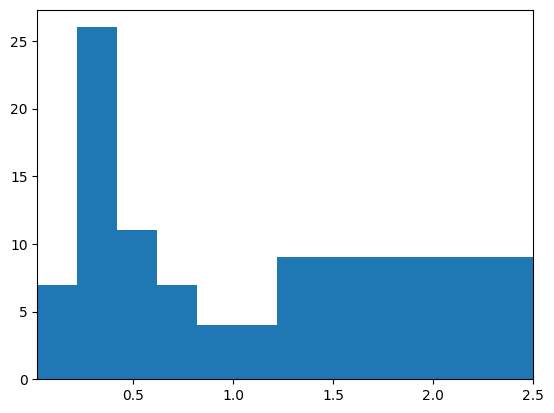

48.670928171876795


In [89]:
beamon_frac_stat_cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
    
selected_data_counts = plt.hist(datasets_dict['data'].query(q)[xvar], bins, range=[bins[0], bins[-1]])[0]
plt.xlim(xlow,xhigh)
plt.show()
    
if background_subtraction==True: 
    selected_data_counts = [a-b for a,b in zip(selected_data_counts,bkgd_event_rate)]
    
print(sum(selected_data_counts))
    
for i in range(len(bins)-1): 
    
    if selected_data_counts[i] != 0: 
        beamon_frac_stat_cov[i][i] = selected_data_counts[i]/(selected_data_counts[i]**2)

beamon_stat_percent_error = np.sqrt(np.diag(beamon_frac_stat_cov))


### MC Response Matrix 

In [90]:
# for the signal channel ONLY 

if background_subtraction: 

    selected_signal_df = datasets_dict['infv'].query(selected_signal_query).copy()
    selected_signal_df['seed'] = selected_signal_df.apply( lambda x: ConcatRunSubRunEvent(x['run'], x['sub'], x['evt']), axis=1 )
    selected_signal_df['weightsPoisson'] = selected_signal_df.apply( lambda x: PoissonRandomNumber(x['seed'], mean=1.0, size=1000), axis=1 )


#### Energy of least energetic electron

In [91]:
if background_subtraction:
    print(selected_signal_df["shr_energy_cali"].min())

0.042283963


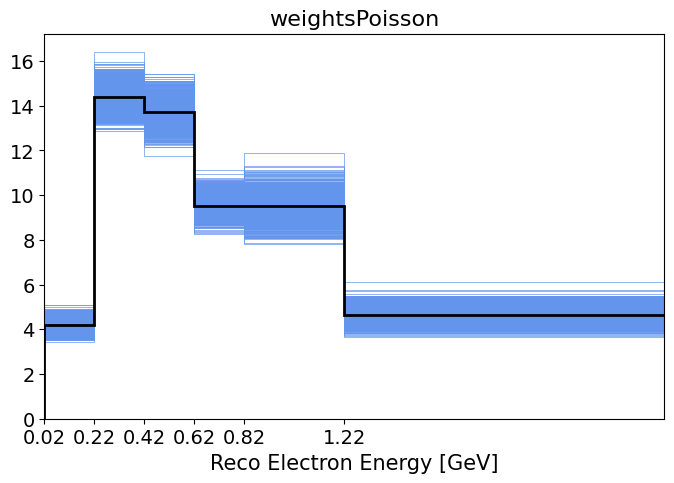

In [92]:
if background_subtraction: 

    fig = plt.figure(figsize=(8, 5))

    # histogram bin counts for all universes
    rmatrix_uni_counts = []

    for u in range(1000): 

        # multiply in with sys weight of universe u 
        sys_weight = list(selected_signal_df['weightsPoisson'].str.get(u))
        total_weight = [ x*y for x, y in zip(sys_weight, selected_signal_df['totweight_data']) ]

        n, b, p = plt.hist(selected_signal_df[xvar], bins, histtype='step', weights=total_weight, 
                                linewidth=0.5, color='cornflowerblue')  

        rmatrix_uni_counts.append(list(n))

    ncv, bcv, pcv = plt.hist(selected_signal_df[xvar], bins, histtype='step', 
                             weights=selected_signal_df['totweight_data'], linewidth=2, color='black')      

    plt.xticks(x_ticks, fontsize=14)
    plt.yticks(fontsize=14)
    
    plt.xlim(xlow, xhigh)

    plt.xlabel('Reco '+x_label, fontsize=15)
    plt.ylabel("", fontsize=15)

    plt.title('weightsPoisson', fontsize=16)    


    plt.show()

In [93]:
if background_subtraction: 
    response_matrix_uncertainty = calcCov(xvar, bins, ncv, evt_rate, rmatrix_uni_counts, isrun3=ISRUN3, plot=False, 
                   save=False, axis_label='Reco '+x_label, pot=parameters(ISRUN3)['beamon_pot'])
    
    response_matrix_uncertainty['fractional_uncertainty']


number of universes =  1000


### POT Counting (2%)

In [94]:
parameters(ISRUN3)['beamon_pot'] 

2e+20

In [95]:
pot_counting = pot_unisims(xvar, evt_rate, bins, 0.02, ISRUN3, plot=plot_variations, x_label=None)

number of universes =  2


### Dirt (100%)  

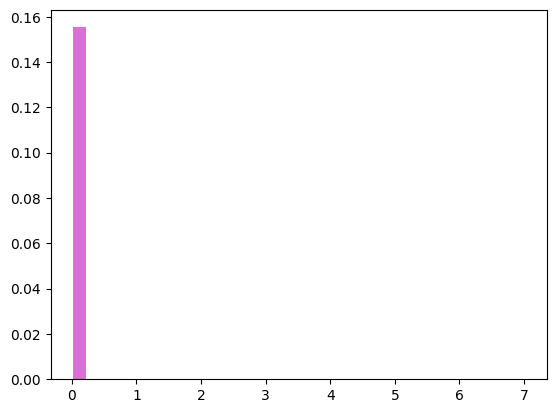

In [96]:
# selected dirt uncertainty 
# vary the dirt interactions by 100% (1 unisim) on the event rate 

selected_dirt = plt.hist(datasets_dict['outfv'].copy().query(q+' and isDirt==1')[xvar], 
                         bins,  
                        weights=datasets_dict['outfv'].copy().query(q+' and isDirt==1')['pot_scale'], 
                         color='orchid')[0]

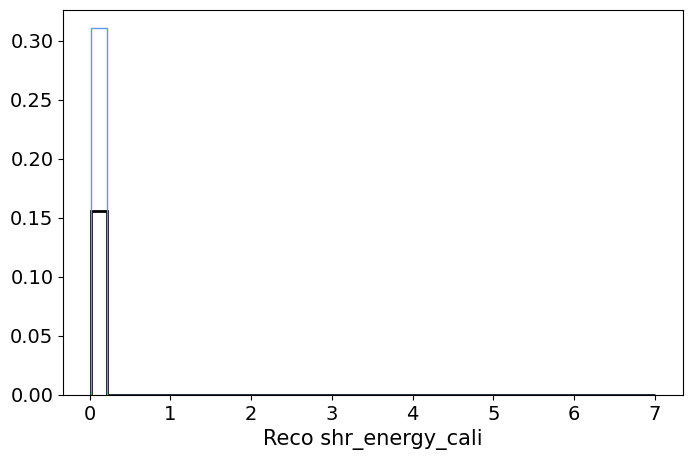

number of universes =  1


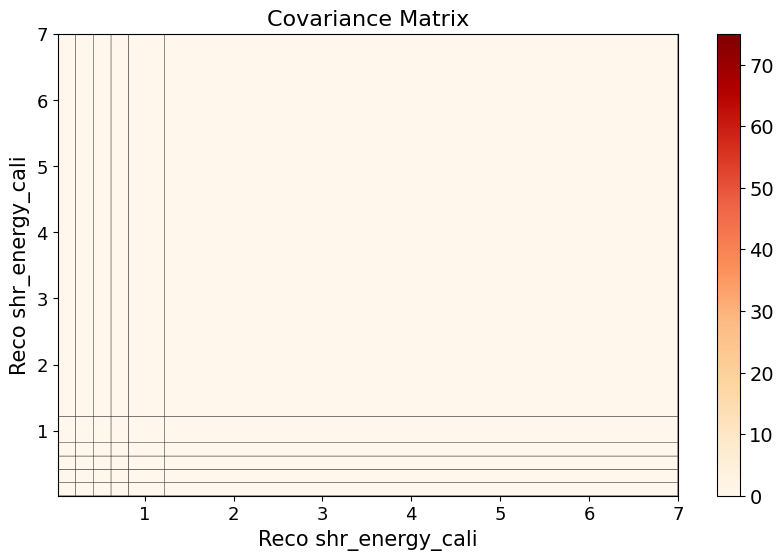

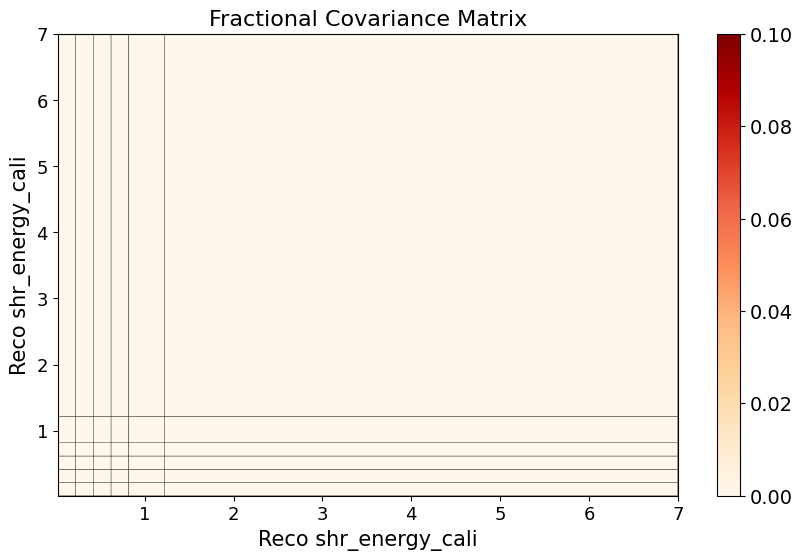

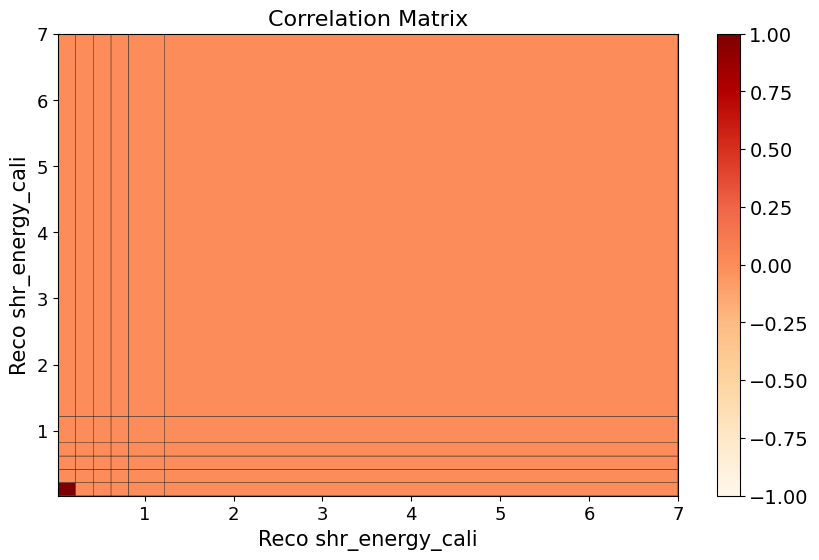

In [97]:
dirt_uncertainty = dirt_unisim(xvar, bins, evt_rate, selected_dirt, 1.0, isrun3=ISRUN3, plot=True, 
                               x_label=None, title=None)

## All Sources of Uncertainty

In [98]:
ISRUN3

False

In [99]:
frac_cov_dict = {
    'ppfx' : ppfx_dict['frac_cov'], 
    'beamline' : beamline_dict['frac_cov'], 
    'genie_ms' : genie_dict['frac_cov'], 
    'genie_us': genie_unisim_dict['frac_cov'], 
    'geant4' : geant4_dict['frac_cov'],
    'pot_counting' : pot_counting['frac_cov'], 
    'dirt' : dirt_uncertainty['frac_cov'],
    'mc_stat' : mc_frac_stat_cov, # either the full distribution or just background events 
    'ext_stat' : ext_frac_stat_cov
}

if detsys: 
    frac_cov_dict['detector'] = detsys_dict['frac_cov']


if background_subtraction: 
    frac_cov_dict['response_matrix'] = response_matrix_uncertainty['frac_cov']
    frac_cov_dict['beamon_stat'] = beamon_frac_stat_cov


Note: Input must be fractional covariance matrices !


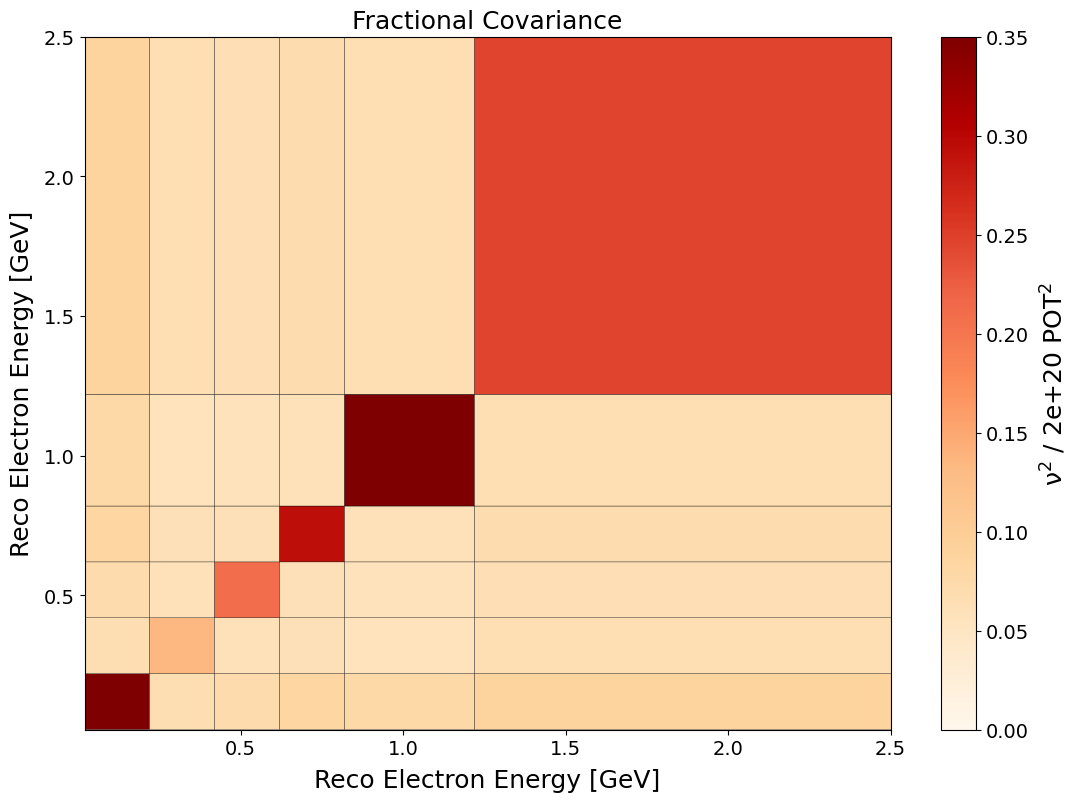

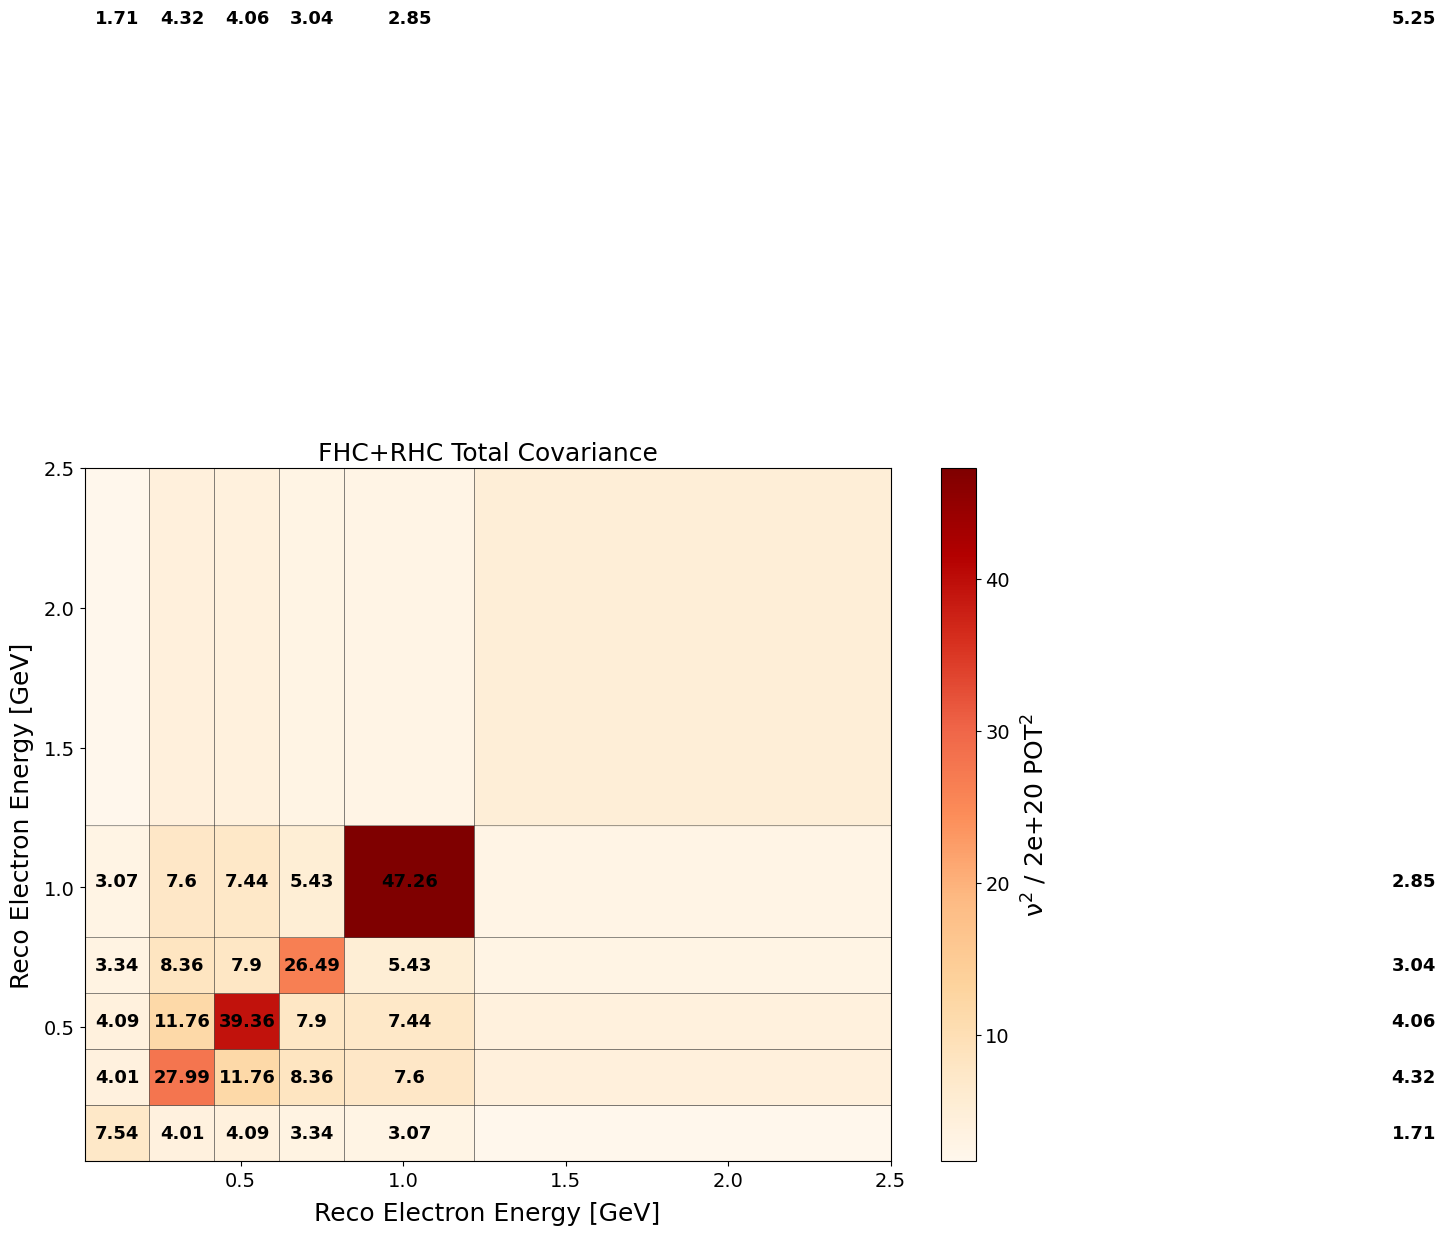

In [100]:
cv = evt_rate

bincenters = 0.5*(np.array(bins)[1:]+np.array(bins)[:-1])

tot_frac_cov, tot_abs_cov = plotFullCov(frac_cov_dict, xvar, cv, bins, xlow, xhigh, bincenters=bincenters, save=False, 
                      axis_label='Reco '+x_label, isrun3=ISRUN3, pot=str(beamon_pot)+' POT')

In [101]:
# add ppfx & beamline geometry in quadrature
frac_cov_dict['flux'] = [ [x+y for x,y in zip(a,b)] for a,b in zip(frac_cov_dict['ppfx'], frac_cov_dict['beamline'])]

# add genie in quadrature
frac_cov_dict['genie_all'] = [ [x+y for x,y in zip(a,b)] for a,b in zip(frac_cov_dict['genie_ms'], frac_cov_dict['genie_us'])]

# add stat stuff in quadrature 

if background_subtraction: 
    
    if isData: # NuMI data / NuWro studies
        frac_cov_dict['stat_all'] = [ [w+x+y+z for w,x,y,z in zip(a,b,c,d)] for a,b,c,d in zip( frac_cov_dict['beamon_stat'], frac_cov_dict['response_matrix'], frac_cov_dict['mc_stat'], frac_cov_dict['ext_stat'])]
    
    else:  # GENIE closure studies
        frac_cov_dict['stat_all'] = [ [x+y+z for x,y,z in zip(b,c,d)] for b,c,d in zip( frac_cov_dict['response_matrix'], frac_cov_dict['mc_stat'], frac_cov_dict['ext_stat'])]

# for mc/data comparisons
else: 
    frac_cov_dict['stat_all'] = [ [x+y for x,y in zip(a,b)] for a,b in zip(frac_cov_dict['mc_stat'], frac_cov_dict['ext_stat'])]


In [102]:
# clean away nans
v = np.array(tot_frac_cov)
v[np.isnan(v)] = 0
tot_frac_cov = v

In [103]:
# clean away nans
v = np.array(tot_abs_cov)
v[np.isnan(v)] = 0
tot_abs_cov = v

In [104]:
frac_unc_dict = {
    'flux' : np.sqrt(np.diagonal(frac_cov_dict['flux'])), 
    'genie' : np.sqrt(np.diagonal(frac_cov_dict['genie_all'])), 
    'geant4' : np.sqrt(np.diagonal(frac_cov_dict['geant4'])),
    'pot_counting' : np.sqrt(np.diagonal(frac_cov_dict['pot_counting'])), 
    'dirt' : np.sqrt(np.diagonal(frac_cov_dict['dirt'])),
    'stat' : np.sqrt(np.diagonal(frac_cov_dict['stat_all'])), # does not include beam on STAT 
    'total' : np.sqrt(np.diagonal(tot_frac_cov))
}

if detsys: 
    frac_unc_dict['detector'] = np.sqrt(np.diagonal(frac_cov_dict['detector']))

In [105]:
tot_unc = [0 for i in range(len(bins)-1)]

for source in frac_unc_dict.keys(): 
    
    if source=='total': 
        continue
    
    # square the list 
    squared = [x**2 for x in frac_unc_dict[source]]
    
    # add in quadrature 
    tot_unc = [a+b for a,b in zip(tot_unc, squared)]
   
tot_unc = np.sqrt(np.array(tot_unc))
tot_unc
 

array([0.65845272, 0.36779222, 0.45742301, 0.54147537, 0.72425296,
       0.49507498])

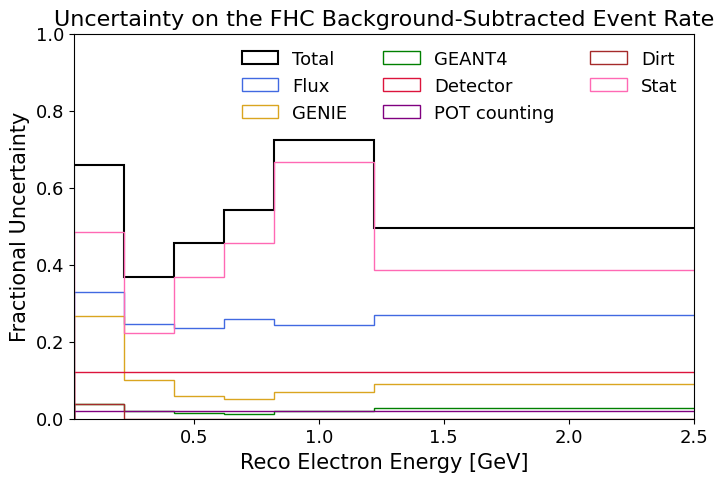

In [106]:
bincenters = 0.5*(np.array(bins)[1:]+np.array(bins)[:-1])

fig = plt.figure(figsize=(8, 5))  

# TOTAL 
plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="Total",
        weights=frac_unc_dict['total'], linewidth=1.5, color='black')

# FLUX
plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="Flux", 
         weights=frac_unc_dict['flux'], color='royalblue')

# CROSS SECTION MODELS 
plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="GENIE", 
         weights=frac_unc_dict['genie'], color='goldenrod')

#plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="GENIE (us)", 
#         weights=np.sqrt(np.diag(frac_cov_dict['genie_us'])), color='goldenrod')

#plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="GENIE (ms)", 
#         weights=np.sqrt(np.diag(frac_cov_dict['genie_ms'])), color='goldenrod', linestyle='--')

plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="GEANT4", 
         weights=frac_unc_dict['geant4'], color='green')

# DETECTOR 
if detsys: 
    plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="Detector", 
         weights=frac_unc_dict['detector'], color='crimson')

# POT COUNTING 
plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="POT counting",
        weights=frac_unc_dict['pot_counting'], color='purple')

# DIRT 
plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="Dirt",
        weights=frac_unc_dict['dirt'], color='brown')

# STATISTICAL 
plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="Stat",
        weights=frac_unc_dict['stat'], color='hotpink')

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.xlabel("Reco " + x_label, fontsize=15)
plt.ylabel("Fractional Uncertainty", fontsize=15)

plt.xlim(bins[0], xhigh)
plt.ylim(0, 1)

plt.legend(fontsize=13, frameon=False, ncol=3)


if background_subtraction: 
    if ISRUN3: 
        plt.title("Uncertainty on the RHC Background-Subtracted Event Rate", fontsize=16)
    else: 
        plt.title("Uncertainty on the FHC Background-Subtracted Event Rate", fontsize=16)
        
else: 
    if ISRUN3: 
        plt.title("Uncertainty on the RHC Selected Event Rate (MC+EXT)", fontsize=16)
    else: 
        plt.title("Uncertainty on the FHC Selected Event Rate (MC+EXT)", fontsize=16)   

plt.show()

## Data/MC Comparisons -- only use for before background subtraction

In [107]:
if not background_subtraction:
    x = plot_mc(
        xvar, bins, xlow, xhigh, q, datasets_dict, ISRUN3,
        norm='data',
        x_label='Reconstructed ' + x_label,
        save=False,
        y_label=y_label,
        xtext=0.9,
        ytext=40
    )

In [108]:
if ISRUN3: 
    chi2_label = "MicroBooNE Run 3 RHC:\n5.0 $\\times 10^{20}$ POT"
    save_label = "rhc_bdttraining" # originally commented out
    beamon_pot_str = "" # originally commented out
    
else: 
    chi2_label = "MicroBooNE Run 1 FHC:\n2.0 $\\times 10^{20}$ POT"
    save_label = "fhc_bdttraining" # originally commented out
    beamon_pot_str = "" # originally commented out
    
print("make sure to update save label!")
print("save label = ", save_label)

make sure to update save label!
save label =  fhc_bdttraining


In [109]:
## compute the chi2 

if not background_subtraction: 
    
    selected_data = plt.hist(datasets_dict['data'].copy().query(q)[xvar], bins)[0]
    plt.close()
    
    tot_cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]

    # inverse cov -- make sure to include the beam on stat covariance! 
    tot_cov_frac = np.array(tot_frac_cov)+np.array(beamon_frac_stat_cov)

    for i in range(len(bins)-1): 
         for j in range(len(bins)-1): 
                tot_cov[i][j] = tot_cov_frac[i][j] * evt_rate[i] * evt_rate[j]

    tot_inverse_cov = np.linalg.pinv(tot_cov)

    ## check 
    plt.pcolor(bins, bins, np.matmul(tot_cov, tot_inverse_cov), cmap='OrRd', edgecolors='k')
    plt.xlim(xlow,xhigh)
    plt.ylim(xlow,xhigh)
    cbar = plt.colorbar()
    plt.show()


    chi2 = 0

    for i in range(len(bins)-1):  
        for j in range(len(bins)-1):  
                chi2 = chi2  + ( (evt_rate[i]-selected_data[i])*tot_inverse_cov[i][j]*(evt_rate[j]-selected_data[j]) )
    print(chi2)

else:
    print("Background subtraction enabled, skipping chi-squared computation.")

Background subtraction enabled, skipping chi-squared computation.


In [110]:
if background_subtraction:
    print(datasets_dict['data'].copy().query(q)[xvar].min())

0.09938547


## Pre-selection, loose cuts plots and BDT plots

In [111]:
# Plot data with the selected query

# sys now takes an array of the total uncertainty

# BDT PLOT can be made here! 125 for FHC, 260 for RHC!

if not background_subtraction:
    d = plot_data(
        xvar, bins, xlow, xhigh, q, datasets_dict, ISRUN3,
        save=True,
        save_label=save_label,
        ymax=250,
        x_label=x_label,
        #x_label="Reconstructed " + x_label,
        #x_label = "Reconstructed " + "$\cos{\\mathit{\\theta}_{\mathrm{ep}}}$", 
        ncol=2,
        text=chi2_label + "\n$\\mathit{\\chi^{2}/n}$ = " + str(round(chi2, 1)) + "/" + str(len(bins) - 1),
        xtext=xlow + 0.1,
        ytext=48,
        x_ticks=x_ticks,
        sys=frac_unc_dict['total']
    )

## Save variations to file -- use for unfolding only

In [112]:
if background_subtraction: 
    print("make sure to change file name!")
    
    variations_dict = {
        'evt_rate' : evt_rate, 
        'beamon_counts' : list(selected_data_counts), 
        'ppfx' : ppfx_variations, 
        'beamline' : beamline_variations, 
        'genie_ms' : genie_variations, 
        'genie_us' : genie_us_variations, 
        'geant4' : geant4_variations,
        'pot_counting' : pot_counting['variations'], 
        'dirt' : dirt_uncertainty['variations'], 
        'response_matrix' : rmatrix_uni_counts, 
        'cv_dirt' : list(selected_dirt), 
        'cv_bkgd' : bkgd_event_rate, # total background event rate (MC+EXT)
        'cv_ext' : list(cv_ext),
        'mc_bkgd_sumw2' : list(mc_bkgd_sumw2), # need to take the square root for fractional uncertainty 
        'ext_sumw2' : list(ext_sumw2), # need to take the square root for fractional uncertainty 
        'mc_signal_sumw2' : mc_signal_sumw2
    }
    

else: 
    print("make sure to change file name!")
    
    variations_dict = {
        'full_evt_rate' : evt_rate, 
        'beamon_full_evt_rate' : list(selected_data_counts), 
        'ppfx' : [list(a) for a in ppfx_variations], 
        'beamline' : beamline_variations, 
        'genie_ms' : [list(a) for a in genie_variations], 
        'genie_us' : genie_us_variations, 
        'geant4' : [list(a) for a in geant4_variations],
        'pot_counting' : pot_counting['variations'], 
        'dirt' : dirt_uncertainty['variations'], 
        'cv_dirt' : list(selected_dirt), 
        'cv_bkgd' : bkgd_event_rate, # total background event rate (MC+EXT)
        'cv_ext' : list(cv_ext), # just the EXT background 
        'mc_bkgd_sumw2' : list(mc_bkgd_sumw2), # need to take the square root for fractional uncertainty 
        'ext_sumw2' : list(ext_sumw2), # need to take the square root for fractional uncertainty 
        'mc_signal_sumw2' : mc_signal_sumw2
    }

make sure to change file name!


In [113]:
from datetime import date  
import json
import os

save = True

# Set the path conditionally based on background_subtraction
if background_subtraction:
    path = 'unfolding/variations/'
else:
    path = 'unfolding/variations/full_event_rates/'

print(path)

if ISRUN3: 
    filename = 'RHCVariations_' + xvar + "_" + date.today().strftime("%m%d%y") + ".json"
else:
    filename = 'FHCVariations_' + xvar + "_" + date.today().strftime("%m%d%y") + ".json"

if save:
    # Check if the file already exists
    if os.path.exists(path + filename): 
        print(filename, "exists and is readable, need to update file name to save!")
    else: 
        # Save the variations_dict to the specified path and filename
        with open(path + filename, 'w') as f:
            json.dump(variations_dict, f)
else:
    print("Saving is disabled; file not saved.")


unfolding/variations/


## NuMI Oscillations (3+1 Model) -- outdated

In [ ]:
# outdated 

x = plot_mc(xvar, [round(0.01*x, 2) for x in range(0, 75, 5)], 0, 0.7, 'BDT_score>0.575', datasets_bdt, ISRUN3, 
        plt_norm='proj', pot='$9.23\\times10^{20}$', ymax=30, x_label='True Neutrino Energy [GeV]', 
            osc='machado_bestfit.csv')

# osc='biggest_variation.csv'

#### Create projected oscillation dictionary 

In [ ]:
import json

In [ ]:
# to load a stored dictionary 
with open('outdated/FHC_Projected_TrueNeutrinoEnergy.json') as f:
    d = json.load(f)

In [ ]:
bins = np.linspace(0, 4.5, 46) #d['bins']

In [ ]:
x = plot_mc('nu_e', bins, 0, 5, selected_query, datasets_bdt, 
            ISRUN3, x_label="Reco $\\nu$ Energy [GeV]", norm='data', pot='$2.0\\times10^{20}$')

In [ ]:
oscillation_dict = {}

In [ ]:
oscillation_dict['bins'] = bins

In [ ]:
pot_scale = 9.23E20/parameters(ISRUN3)['beamon_pot']
print(pot_scale)

In [ ]:
oscillation_dict['CV'] = [k*pot_scale for k in x['CV']]

In [ ]:
ncv, ppfx_variations = plotSysVariations('nu_e', 'nu_e', bins, bins[0], bins[-1], selected_query, datasets_bdt, 'weightsPPFX',600, 
                                         ISRUN3, plot=False, axis_label='True Neutrino Energy [GeV]', pot='$2.0 x 10^{20}$ POT', 
                                              background_subtraction=False)

ppfx_dict = calcCov('nu_e', bins, ncv, ppfx_variations, plot=False, save=False, 
                    axis_label='True Neutrino Energy [GeV] ', pot='$2.0 x 10^{20}$ POT', isrun3=ISRUN3, title='Hadron Production')

In [ ]:
oscillation_dict['ppfx_cov_frac'] = ppfx_dict['frac_cov']

In [ ]:
ncv, genie_variations = plotSysVariations('nu_e', 'nu_e', bins, bins[0], bins[-1], selected_query, datasets_bdt, 'weightsGenie',600, 
                                         ISRUN3, plot=True, axis_label='True Neutrino Energy [GeV]', pot='$2.0 x 10^{20}$ POT', 
                                              background_subtraction=False)

genie_dict = calcCov('nu_e', bins, ncv, genie_variations, plot=False, save=False, 
                    axis_label='True Neutrino Energy [GeV] ', pot='$2.0 x 10^{20}$ POT', isrun3=ISRUN3, title='Hadron Production')

In [ ]:
oscillation_dict['genie_cov_frac'] = genie_dict['frac_cov']

In [ ]:
ncv, geant4_variations = plotSysVariations('nu_e', 'nu_e', bins, bins[0], bins[-1], selected_query, datasets_bdt, 'weightsReint',1000, 
                                         ISRUN3, plot=True, axis_label='True Neutrino Energy [GeV]', pot='$2.0 x 10^{20}$ POT', 
                                              background_subtraction=False)


geant4_dict = calcCov('nu_e', bins, ncv, geant4_variations, plot=False, save=False, 
                    axis_label='True Neutrino Energy [GeV] ', pot='$2.0 x 10^{20}$ POT', isrun3=ISRUN3, title='Hadron Production')

In [ ]:
oscillation_dict['reint_cov_frac'] = geant4_dict['frac_cov']

In [ ]:
## detector variations -- make new file 
recreate_file=True

In [ ]:
if recreate_file: 
    for v in list(detvar_run1_fhc.keys()): 
        NuMIDetSysWeights.makehist_detsys(v, ISRUN3, "NuMI_FHC_BDT_DetectorVariations_OscillationAnalysis_v2.root", 'nu_e', 
                                          bins, cut=selected_query, useBDT=True)

In [ ]:
detector_variations = NuMIDetSysWeights.plot_variations('nu_e', bins, "NuMI_FHC_BDT_DetectorVariations_OscillationAnalysis_v2.root", 
                                                        ISRUN3, axis_label='True Neutrino Energy', plot=True, background_subtraction=False)

In [ ]:
# compute covariance (N=1 for each variation)

detsys_cov = {}

# index in weightsNuMIGeo are offset by -1

for variation in detector_variations.keys(): 
    
    if variation=='CV': 
        continue
    
    # calc covariance for each unisim 
    detsys_cov[variation] = calcCov('nu_e', bins, detector_variations['CV'], [detector_variations[variation]], 'Detector', 
                                    plot=False, save=False, pot='$2.0 x 10^{20}$ POT', isrun3=ISRUN3,
                                   title=variation)

In [ ]:
# compute total covariance, correlation, & uncertainty 

cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
frac_cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
cor = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]

for variation in detsys_cov.keys(): 
    
    for i in range(len(bins)-1): 
        for j in range(len(bins)-1):
            
            cov[i][j] = sum([detsys_cov[x]['cov'][i][j] for x in detsys_cov.keys()])
            
            if detector_variations['CV'][i]*detector_variations['CV'][j] != 0: 
                frac_cov[i][j] = cov[i][j]/(detector_variations['CV'][i]*detector_variations['CV'][j])

            
for i in range(len(bins)-1): 
    for j in range(len(bins)-1):
        
        if np.sqrt(cov[i][i])*np.sqrt(cov[j][j]) != 0: 
                cor[i][j] = cov[i][j] / (np.sqrt(cov[i][i])*np.sqrt(cov[j][j]))
            
detsys_dict = {
    'cov' : cov, 
    'frac_cov' : frac_cov,
    'cor' : cor,
    'fractional_uncertainty' : np.sqrt(np.diag(frac_cov))
} 

In [ ]:
oscillation_dict['det_cov_frac'] = detsys_dict['frac_cov']

In [ ]:
tot_frac_cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]

for source in list(oscillation_dict.keys())[2:]: 
    tot_frac_cov = [ [x+y for x,y in zip(a,b)] for a,b in zip(tot_frac_cov, oscillation_dict[source])]

In [ ]:
oscillation_dict['tot_cov_frac'] = tot_frac_cov

In [ ]:
oscillation_dict.keys()


In [ ]:
oscillation_dict['bins'] = oscillation_dict['bins'].tolist()

In [ ]:
# save this dictionary 

with open('mun/FHC_Projected_TrueNeutrinoEnergy_March2022_v2.json', 'w') as f:
    json.dump(oscillation_dict, f)